In [45]:
from collections import defaultdict
import numpy as np
import pandas as pd
from tqdm import tqdm
from gensim.models import Word2Vec, KeyedVectors
from nltk.tokenize import RegexpTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt

In [1]:
num_clusters = 10
num_seed_words = 15
num_plot = 10

In [ ]:
TODO: intersect comment and fine-tuning vocab

# load word vectors

In [11]:
def process_text(text_list, lemmatize=True, stop_words=None):
    tokenizer = RegexpTokenizer(r'\w+')
    tokenized_text = [s.lower() for s in text_list]
    tokenized_text = [tokenizer.tokenize(s) for s in tokenized_text]
    processed_text = []
    for tokens in tqdm(tokenized_text):
        if stop_words != None:
            tokens = [token for token in tokens if token not in stop_words]
        if lemmatize:
            lemmatizer = WordNetLemmatizer()
            tokens = [lemmatizer.lemmatize(token) for token in tokens]
        processed_text.append(tokens)
    return processed_text

In [21]:
comment_file = "../processed/comments.pkl"
df_comment = pd.read_pickle(comment_file)
comment_list = df_comment.comment.astype('str').tolist()
comments = process_text(comment_list, lemmatize=True)

100%|██████████| 135479/135479 [00:32<00:00, 4222.96it/s]


In [27]:
print(comments[0])

['that', 'wa', 'another', 'administration']


In [23]:
model = Word2Vec(size=300)
model.build_vocab(comments)
total_examples = model.corpus_count

In [26]:
model.intersect_word2vec_format("../wv/w2v_corpus_trained.bin", binary=True)
print(model.wv.vectors.shape)

(20908, 300)


# K-means

In [34]:
%%time
# load specific word embeddings that you want 
# w2v_model = Word2Vec.load('../wv/w2v_comment_raw.model')
# w2v_model = Word2Vec.load('../wv/w2v_comment_trained.model')
# w2v_model = Word2Vec.load('../wv/w2v_comment_stopword_trained.model')
# w2v = w2v_model.wv.vectors
w2v_keyedvector = KeyedVectors.load_word2vec_format('../wv/w2v_corpus_trained.bin', binary=True)
w2v = w2v_keyedvector.vectors
n_words = w2v.shape[0]

Wall time: 1.08 s


In [35]:
print(n_words)

19379


## elbow method

https://www.geeksforgeeks.org/ml-determine-the-optimal-value-of-k-in-k-means-clustering/

100%|██████████| 40/40 [15:32<00:00, 23.32s/it]


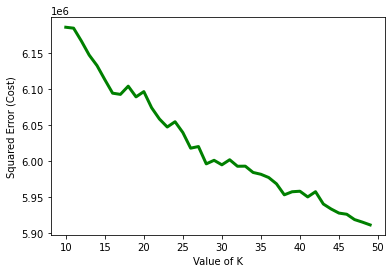

In [36]:
cost = []
for i in tqdm(range(10, 50)):
    kmeans = KMeans(n_clusters=i, max_iter=500)
    kmeans.fit(w2v)
    cost.append(kmeans.inertia_)
plt.plot(range(10, 50), cost, color='g', linewidth='3')
plt.xlabel("Value of K")
plt.ylabel("Squared Error (Cost)")
plt.show()

In [37]:
for i in tqdm(range(50, 70)):
    kmeans = KMeans(n_clusters=i, max_iter=500)
    kmeans.fit(w2v)
    cost.append(kmeans.inertia_)

100%|██████████| 20/20 [17:03<00:00, 51.17s/it]


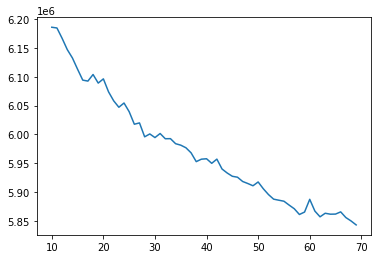

In [38]:
plt.plot(range(10, 70), cost)
plt.show()

In [41]:
cost_pre = []
for i in tqdm(range(2, 5)):
    kmeans = KMeans(n_clusters=i, max_iter=500)
    kmeans.fit(w2v)
    cost_pre.append(kmeans.inertia_)

100%|██████████| 3/3 [00:13<00:00,  4.53s/it]


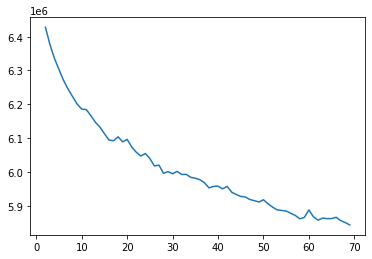

In [42]:
cost = cost_pre + cost
plt.plot(range(2, 70), cost)
plt.show()

## AIC and BIC

https://jakevdp.github.io/PythonDataScienceHandbook/05.12-gaussian-mixtures.html


 15%|█▌        | 3/20 [00:30<02:34,  9.08s/it]E:\Anaconda3\envs\nlp\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)

100%|██████████| 20/20 [25:56<00:00, 77.83s/it] 


Text(0.5, 0, 'n_components')

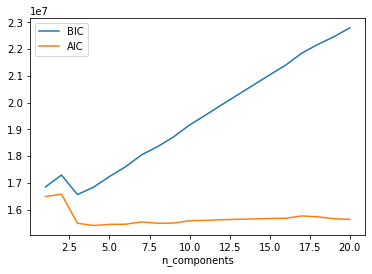

In [48]:
n_components = np.arange(1, 21)
models = []
for n in tqdm(n_components):
    models.append(GaussianMixture(n, covariance_type='full', random_state=0).fit(w2v))
# models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(w2v) for n in tqdm(n_components)]

plt.plot(n_components, [m.bic(w2v) for m in models], label='BIC')
plt.plot(n_components, [m.aic(w2v) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components')

In [33]:
%%time
kmeans = KMeans(n_clusters=num_clusters, n_jobs=-1, random_state=0)
cluster_idx = kmeans.fit_predict(w2v)
X_dist = kmeans.transform(w2v)**2   # [N, n_clusters]
X_dist_cluster = X_dist[range(n_words), cluster_idx]    # distance away from corresponding centroid

E:\Anaconda3\envs\nlp\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)
Wall time: 8.52 s


In [6]:
print(cluster_idx)
print(X_dist[:5])
print(X_dist_cluster[:5])
print((cluster_idx == kmeans.labels_).all())

[1 1 1 ... 9 3 3]
[[179.13173  137.00194  193.87825  177.47969  193.3314   177.02106
  168.82529  173.22714  182.8256   185.25311 ]
 [171.40483  131.49051  184.00491  170.96881  180.87422  169.39629
  150.22865  165.08096  175.47403  179.77316 ]
 [151.09143  122.3203   167.26482  150.01762  166.97017  153.57074
  147.65804  149.19392  157.70093  159.98538 ]
 [155.71399  126.27024  178.0807   158.49998  174.05518  161.24652
  166.95876  158.87984  173.24068  171.22913 ]
 [ 96.48745   75.2812   102.327675  95.48899  109.38654  102.06563
  101.55417   94.285416 100.5368   104.979744]]
[137.00194 131.49051 122.3203  126.27024  75.2812 ]
True


In [7]:
print(kmeans.cluster_centers_)

[[ 0.1573746  -0.03161293  0.09015757 ... -0.10407139  0.01624244
   0.08505712]
 [ 0.01460415 -0.24699414  0.02113412 ...  0.07806721  0.02449858
  -0.38729352]
 [ 0.06255164 -0.09208041  0.19650783 ...  0.0964964  -0.09674358
  -0.14295304]
 ...
 [-0.04870617  0.09583761 -0.0424     ... -0.06899892  0.07716087
   0.04717332]
 [-0.14176169  0.14207739  0.00804573 ...  0.03974606  0.091887
   0.14099199]
 [-0.12434358  0.19872275  0.03374029 ...  0.12119108  0.29525313
   0.10073412]]


In [34]:
word_cluster_list = list(zip(w2v_model.wv.index2word, cluster_idx, X_dist_cluster))
# each tuple: (word string, cluster, distance to its cluster centroid)
# word_cluster_list_sort = sorted(word_cluster_list, key=lambda el:el[1], reverse=False)
print(word_cluster_list[:10])

[('the', 8, 113.26455), ('to', 8, 226.9502), ('and', 8, 79.77692), ('a', 8, 118.12551), ('of', 0, 182.5236), ('is', 4, 222.25925), ('that', 4, 132.82294), ('in', 0, 200.23831), ('it', 4, 147.22539), ('i', 2, 317.50107)]


In [38]:
cluster_word_dict = defaultdict(list)
# each cluster is a list, storing corresponding words
for word in word_cluster_list:
    cluster_word_dict[word[1]].append(word)

cluster_word_dict_sorted = defaultdict(list)
for c in sorted(cluster_word_dict.keys()):
    # in each cluster, sort the words with their euclidean distance to the centroid
    cluster_word_dict_sorted[c] = [(t[0], t[2]) for t in sorted(cluster_word_dict[c], key=lambda el:el[2], reverse=False)]
    # print(c, cluster_word_dict_sorted[c][:num_seed_words], '\n')
    print_words = [word[0] for word in cluster_word_dict_sorted[c][:num_seed_words]]
    print(c, print_words, '\n')

0 ['diversification', 'principally', 'restoration', 'intercropping', 'topography', 'transportability', 'agroforestry', 'fostering', 'estuary', 'offsetting', 'biodiverse', 'facilitating', 'monocrop', 'compaction', 'centralization'] 

1 ['countered', 'championed', 'infiltrated', 'applauded', 'graded', 'lectured', 'deployed', 'misinterpreted', 'alarmed', 'stimulated', 'vetted', 'alerted', 'hammered', 'tapped', 'ensured'] 

2 ['toasted', 'croissant', 'fluffy', 'parsnip', 'creamy', 'crusty', 'beetroot', 'aloe', 'unsalted', 'anchovy', 'fennel', 'dumpling', 'buttery', 'galettes', 'tomatillo'] 

3 ['foist', 'procure', 'broaden', 'discern', 'overwhelm', 'conceive', 'impress', 'fathom', 'align', 'empower', 'prioritize', 'decimate', 'accommodate', 'peddle', 'enact'] 

4 ['caricature', 'arrogantly', 'unhelpful', 'histrionics', 'zealous', 'naïve', 'nitpicking', 'conspiratorial', 'trite', 'intersting', 'belittling', 'uncritical', 'innuendo', 'nutcase', 'insinuation'] 

5 ['hess', 'enser', 'as_sdt', 

In [36]:
%%time
tsne = TSNE(n_components=2, init='pca', verbose=1)
vocab_emb = tsne.fit_transform(w2v)
print(vocab_emb.shape)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 16803 samples in 0.008s...
[t-SNE] Computed neighbors for 16803 samples in 10.591s...
[t-SNE] Computed conditional probabilities for sample 1000 / 16803
[t-SNE] Computed conditional probabilities for sample 2000 / 16803
[t-SNE] Computed conditional probabilities for sample 3000 / 16803
[t-SNE] Computed conditional probabilities for sample 4000 / 16803
[t-SNE] Computed conditional probabilities for sample 5000 / 16803
[t-SNE] Computed conditional probabilities for sample 6000 / 16803
[t-SNE] Computed conditional probabilities for sample 7000 / 16803
[t-SNE] Computed conditional probabilities for sample 8000 / 16803
[t-SNE] Computed conditional probabilities for sample 9000 / 16803
[t-SNE] Computed conditional probabilities for sample 10000 / 16803
[t-SNE] Computed conditional probabilities for sample 11000 / 16803
[t-SNE] Computed conditional probabilities for sample 12000 / 16803
[t-SNE] Computed conditional probabilities for sa

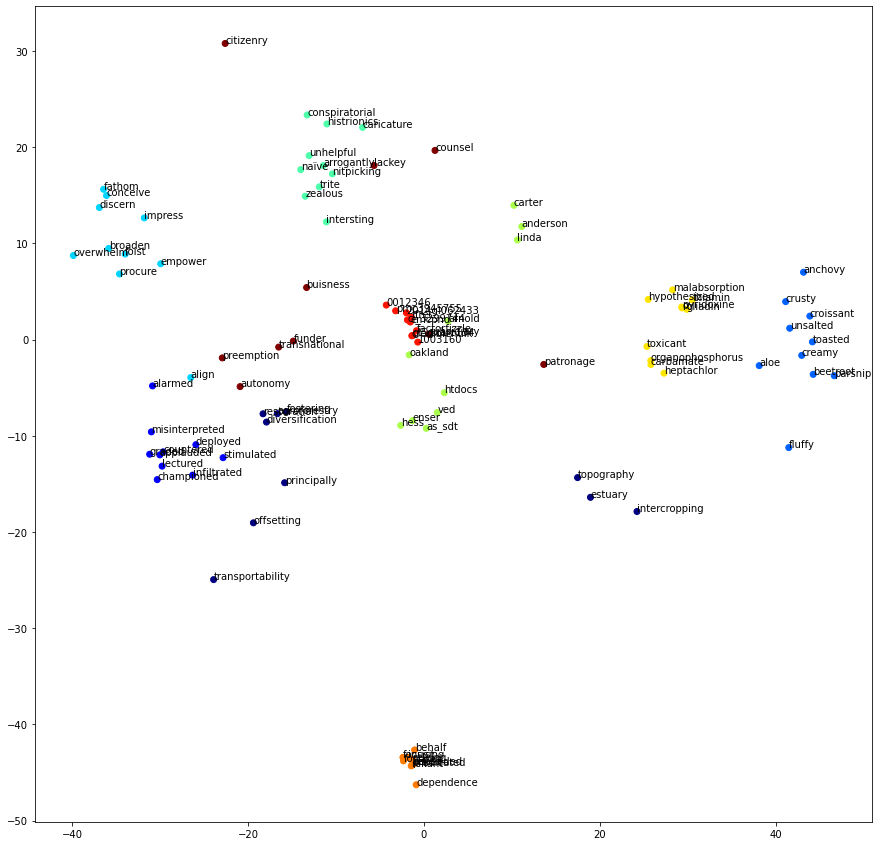

In [37]:
# word2index = {token: token_idx for token_idx, token in enumerate(w2v_model.wv.index2word)}
plt.figure(figsize=(15,15))
word_idx = []
for i, c in enumerate(cluster_word_dict_sorted.keys()):
    # word_idx = []
    draw_words = [word[0] for word in cluster_word_dict_sorted[c][:num_plot]]
    for word in draw_words:
        idx = w2v_model.wv.vocab[word].index
        word_idx.append(idx)
        # plt.scatter(vocab_emb[idx, 0], vocab_emb[idx, 1], c=colors[i], cmap='jet')
        plt.annotate(word, xy=(vocab_emb[idx, 0], vocab_emb[idx, 1]))
        # plt.text(vocab_emb[idx, 0], vocab_emb[idx, 1], word)
    # print(word_idx)
    # print(draw_words)
    # plt.scatter(vocab_emb[word_idx, 0], vocab_emb[word_idx, 1], c=[i]*num_plot, cmap='jet')

colors = []
# construct color array for all points
for i in range(num_clusters):
    colors += [i] * num_plot
plt.scatter(vocab_emb[word_idx, 0], vocab_emb[word_idx, 1], c=colors, cmap='jet')
plt.show()

# some other code for colored plot
# for i in range(X.shape[0]):
#     plt.text(X[i, 0], X[i, 1], str(y[i]), color=plt.cm.Set1(y[i]), fontdict={'weight': 'bold', 'size': 9})

# NMF

- different options w.r.t. documents
    - segment as document
    - sentence as document
    - whole comment as document
    - all comments in one product as document

# Clarity Scoring Function